In [1]:
import os

import skimage
from skimage import data
from skimage.util import img_as_uint
from skimage.transform import resize
import numpy as np
from numpy import matlib
from sklearn.datasets import load_svmlight_file
import matplotlib.pylab as plt
from matplotlib.pyplot import imshow
import scipy.ndimage
import scipy.signal
import scipy

import scfw.poisson as ps
from scfw.scopt import scopt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

## Data load and preprocessing

In [4]:
def blur_image(im, scale_factor=10):
    blur = np.array([0.011178978813925, 0.050100707167907, 0.082602101584847, 0.050100707167907, 0.011178978813925,
                     0.050100707167907, 0.224535791730617, 0.370196935859762, 0.224535791730617, 0.050100707167907,
                     0.082602101584847, 0.370196935859762, 0.610351562500000, 0.370196935859762, 0.082602101584847,
                     0.050100707167907, 0.224535791730617, 0.370196935859762, 0.224535791730617, 0.050100707167907,
                     0.011178978813925, 0.050100707167907, 0.082602101584847, 0.050100707167907, 0.011178978813925])
    blur *= 1e-4

    im = img_as_uint(im)
    im *= scale_factor
    im_star = scipy.ndimage.convolve(im, blur.reshape(1, -1), mode='constant')
    y = np.random.poisson(im_star)
    y = np.round(y)
    return im_star, y

In [5]:
def matlab_gauss2d(shape, sigma):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m, n = [(ss - 1) / 2 for ss in shape]
    y, x = np.ogrid[-m : m + 1, -n : n + 1]
    h = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [20]:
im = data.camera()
im = resize(im, (im.shape[0] / 2, im.shape[1] / 2))
im = img_as_uint(im).astype(float)
# im_star, y = blur_image(im, 1)

peak = 30
b = 0 # background intensity

# scaling of the underlying image so as to simulate the 
# level of the poisson noise. The smaller the values of the original
# intensities the higher the noise level. 
fs = im.flatten(order='F').reshape(-1, 1) / np.max(im) * peak + b

h = matlab_gauss2d((9, 9), 4)
yb = scipy.ndimage.convolve(fs, h, mode='wrap') # wrap -- circular convolution
# yb = scipy.signal.convolve2d(fs, h, mode='same', boundary='wrap')
rs = np.random.RandomState(1)
Y_rhs = rs.poisson(yb)

M, N = im.shape
Y_rhs = Y_rhs.reshape(M, N, order='F').astype(float)

In [21]:
# skimage.io.imsave('data/cameraman256.png', im.astype(np.uint16))

In [22]:
Y_rhs[0, :10]

array([15., 16., 17., 22., 26., 16., 15., 22., 22., 17.])

Text(0.5, 1.0, 'Noise')

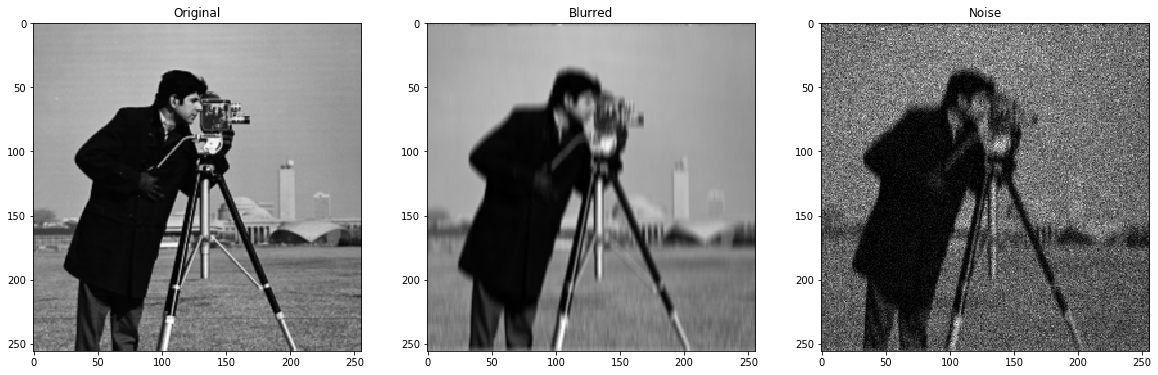

In [23]:
plt.figure(figsize=(20, 7))

plt.subplot(131)
imshow(im, 'gray')
plt.title('Original')

plt.subplot(132)
imshow(yb.reshape(M, N, order='F'), 'gray')
plt.title('Blurred')

plt.subplot(133)
imshow(Y_rhs, 'gray')
plt.title('Noise')

M - number of objects

N - number of features

## Parameters initialization

### From JMLR paper

In [24]:
lam = 5e-5
mu = 1e-10

original_A_opr = lambda x: ps.A_opr(x, h)
original_AT_opr = lambda x: ps.AT_opr(x, h)

prob_A_opr = lambda x: ps.A_opr_blur(x, h)
prob_AT_opr = lambda x: ps.AT_opr_blur(x, h)

Y_g_zero = Y_rhs[Y_rhs > 0]
Mf = max(2 / np.sqrt(Y_g_zero))

#### Starting point

In [25]:
A_f = original_A_opr(im)
AT_y = original_AT_opr(Y_rhs)
x_tmp = original_AT_opr(np.ones_like(Y_rhs, dtype=float)).sum()
X = (Y_rhs.sum() * AT_y.size) / (AT_y.sum() * x_tmp) * AT_y
Z = scipy.fftpack.dctn(X, norm='ortho')

Итого:

- Y_rhs -- M x N
- x_0 -- M x N

In [26]:
#first set of parameters
nu = 3

#running parameters
# x0 = np.ones(n) / n
terminate_tol = 1e-5
# M = ps.poisson(W, y, lam, x0)[0] / lam

FW_params={
    'iter_FW': 50000,
    'line_search_tol': 1e-10,
}

sc_params={
    #parameters for SCOPT
    'iter_SC': 500,
    'Lest': 'estimate', #estimate L
    'use_two_phase': True,
    #FISTA parameters
#     'fista_type': 'mfista',
    'fista_type': 'rfista',
    'fista_tol': 1e-9,
#     'fista_iter': 1000,
    'fista_iter': 30,
    #Conjugate Gradient Parameters
#     'conj_grad_tol': 1e-2,
#     'conj_grad_iter': 100,
}

## Auxilary functions

In [27]:
func_x = lambda x: ps.poisson_pict(Y_rhs, x, h, mu)
# grad_x = lambda x, dot_product: ps.grad_poisson(W, y, lam, x, dot_product)
grad_x = lambda x, Ax: ps.grad_pict(Y_rhs, x, h, mu, Ax)
# grad_beta = lambda X, s, beta, dot_product, dot_product_s: ps.grad_poisson_pict(W, y, lam, (1 - beta) * x + beta * s, (1 - beta) * dot_product + beta * dot_product_s)
hess_mult_x = lambda x, Ax: ps.hess_mult_pict(Y_rhs, x, h, mu, Ax)
hess_mult_vec_x = lambda s, As: ps.hess_mult_vec_pict(Y_rhs, s, h, mu, As)
extra_func = lambda x: W @ x
# linear_orcale = lambda grad: ps.linear_oracle_full_simplex(grad, M)
prox_func = lambda x, L: np.maximum(x, 0) #used for SCOPT

## Run SCOPT

In [28]:
x, alpha_hist, Q_hist, time_hist = scopt(func_x,
          grad_x,
          hess_mult_x,
          hess_mult_vec_x,
          Mf,
          nu,
          prox_func,
          Z,  
          sc_params,
          eps=terminate_tol,
          print_every=1)
    
results[problem_name]['scopt'] = {
    'x': x,
    'alpha_hist': alpha_hist,
    #'Gap_hist': Gap_hist,
    'Q_hist': Q_hist,
    'time_hist': time_hist,
}

Fista err = 4.237e-19; Subiter =   2; subproblem converged!

iter =    1, stepsize = 1.043e-03, rdiff = 2.699e-01

Fista err = 4.222e-19; Subiter =   2; subproblem converged!

iter =    2, stepsize = 1.043e-03, rdiff = 2.696e-01

Fista err = 4.206e-19; Subiter =   2; subproblem converged!

iter =    3, stepsize = 1.043e-03, rdiff = 2.694e-01

Fista err = 4.190e-19; Subiter =   2; subproblem converged!

iter =    4, stepsize = 1.043e-03, rdiff = 2.691e-01

Fista err = 4.172e-19; Subiter =   2; subproblem converged!

iter =    5, stepsize = 1.043e-03, rdiff = 2.688e-01

Fista err = 4.154e-19; Subiter =   2; subproblem converged!

iter =    6, stepsize = 1.043e-03, rdiff = 2.686e-01

Fista err = 4.135e-19; Subiter =   2; subproblem converged!

iter =    7, stepsize = 1.043e-03, rdiff = 2.683e-01

Fista err = 4.115e-19; Subiter =   2; subproblem converged!

iter =    8, stepsize = 1.043e-03, rdiff = 2.681e-01

Fista err = 4.094e-19; Subiter =   2; subproblem converged!

iter =    9, stepsi

NameError: name 'results' is not defined